# Introduction: 

This Jupyter Lab notebook documents the computational analysis performed as part of the manuscript revisions for our study on the co-essentiality network in Mycobacterium tuberculosis (Mtb). The analysis aims to refine our understanding of gene-gene interactions and to identify clusters of genes, referred to as NN2 subgraphs, that are potentially co-essential for the bacterium's survival and pathogenicity.

## Background
Genome-wide random mutagenesis screens using transposon sequencing (TnSeq) have been a cornerstone of functional genetics in Mtb. Our initial manuscript presented a co-essentiality analysis across the Mtb genome, revealing clusters of genes with similar function. However, peer review feedback highlighted the need for a more rigorous approach to identify and validate these gene clusters.

## Objectives
The following key objectives were addressed in this notebook:

### 1. Filtering Outlier-Driven Correlations: 
We refined our pairwise gene correlation data to exclude instances where the correlation was driven by outliers, ensuring that our subsequent analyses are based on robust and meaningful interactions.

### 2. Generating NN2 Subgraphs: 
We implemented an algorithm to systematically search for and generate second-nearest neighbor (NN2) subgraphs from the co-essentiality network, starting from each gene as a seed.

### 3. Filtering Unique Subgraphs: 
To avoid redundancy, we developed a method to filter out duplicate or similar NN2 subgraphs, utilizing the Jaccard similarity index to quantify the similarity between subgraphs.

### 4. Analyzing Subgraph Sizes and Statistics: 
We observed the distribution of NN2 subgraph sizes to identify and further investigate unusually large subgraphs, as they may represent key functional clusters or areas of interest for further biological validation.

# Setup: Import all necessary libraries

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Load datasets: 

In [6]:
path_data = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/GLS_TnSeq_v2/'
fn_interact = 'test_SI_data_1_fdr.001.xlsx'
fn_interact_path = os.path.join(path_data, fn_interact)
df_interact = pd.read_excel(fn_interact_path)

# LFC dataset
fn_lfc = '../data/standardized_data/old_std_data/result_logfc_matrix_2021_11_15_BASIS_invitro.csv'
df_lfc_gls = pd.read_csv(fn_lfc, index_col=0)
df_lfc_gls.dropna(axis=0, inplace=True)

# PART 1: Filter out significant GLS correlations that are driven by single outlier points:

In this phase, we aim to refine the quality of our gene correlation data by identifying and removing any gene-gene interactions that are disproportionately influenced by single outlier data points. Such outliers can skew the perceived strength and direction of a gene pair's correlation, potentially leading to false assumptions about their co-essentiality. By excluding these outlier-driven correlations, we ensure that our analysis is based on more stable and reliable gene interactions, providing a clearer view of the genetic landscape we are investigating.



First, in preparation for this, we configure the data for Generalized Least Squares (GLS) regression by transforming the log-fold change (LFC) values from the TnSeq screens. We start by computing the covariance matrix of the data to account for the interdependencies between different TnSeq experiments. We then invert this matrix to use it in the Cholesky decomposition, which allows us to transform the data (i.e., "warp" the screens) into a new space where the GLS assumptions hold, specifically that the errors are uncorrelated and homoscedastic. The resulting warped_screens provide a suitable basis for the subsequent GLS correlation analysis.



In [7]:
mat_data = df_lfc_gls.values
cov_mat = np.cov(mat_data.T)
inv_mat = np.linalg.inv(cov_mat)

cholsigmainv = np.linalg.cholesky(inv_mat)
warped_screens = df_lfc_gls.values @ cholsigmainv
warped_intercept = cholsigmainv.sum(axis=0)

#### Here we address potential duplication within our interaction data to ensure the uniqueness of gene pairs for accurate analysis. 

The df_interact DataFrame comprises gene pairs, with each row containing a 'lead_gene' and a 'partner_gene', indicative of a significant GLS correlation between them.



In [11]:
# Assuming df_interact is your DataFrame with columns 'lead_gene' and 'partner_gene'
# Normalize the order of gene pairs
df_interact['sorted_gene_pair'] = df_interact.apply(lambda row: tuple(sorted([row['lead_gene'], row['partner_gene']])), axis=1)
# Identify duplicates based on the sorted gene pairs
duplicates = df_interact[df_interact.duplicated(subset='sorted_gene_pair', keep=False)]
# Drop duplicates based on the sorted gene pairs
df_interact = df_interact.drop_duplicates(subset='sorted_gene_pair')
# get gene pairs in list form
gene_pairs = [(row.lead_gene, row.partner_gene) for row in df_interact.itertuples()]

print(df_interact.shape)
df_interact.head()

(5610, 4)


,lead_gene,partner_gene,p_value_FDR,sorted_gene_pair
0,Rv0001,Rv0062,1.962568e-04,"(Rv0001, Rv0062)"
1,Rv0001,Rv0283,4.421194e-09,"(Rv0001, Rv0283)"
2,Rv0001,Rv0415,6.310410e-09,"(Rv0001, Rv0415)"
3,Rv0001,Rv0537c,3.644942e-04,"(Rv0001, Rv0537c)"
4,Rv0001,Rv2247,2.852074e-07,"(Rv0001, Rv2247)"


#### Some function definitions:

In [100]:
def get_warped_screen_for_gene(gene_id, df, warped_screens):
    """
    Retrieve the warped screen data for a specific gene.

    Parameters:
    gene_id (str): The identifier of the gene.
    df (DataFrame): The DataFrame containing gene information.
    warped_screens (ndarray): The array of warped screens data.

    Returns:
    ndarray: The warped screen data corresponding to the given gene_id.
    """
    # Get the index of the gene in the DataFrame
    gene_index = df.index.get_loc(gene_id)
    
    # Extract the corresponding row from warped_screens
    gene_warped_screen = warped_screens[gene_index]

    return gene_warped_screen


def compute_gls_correlation(warped_gene1, warped_gene2, warped_interc):
    """
    Compute the GLS correlation coefficient and standard error between two genes.

    Parameters:
    warped_gene1 (ndarray): Warped screen data for the first gene.
    warped_gene2 (ndarray): Warped screen data for the second gene.
    warped_interc (ndarray): The intercept term for the GLS regression.

    Returns:
    float: The GLS correlation coefficient.
    float: The standard error of the GLS correlation.
    """
    # Reshape the genes' data for linear regression
    X = np.stack((warped_interc, warped_gene1), axis=1)
    y = warped_gene2

    # Run linear regression
    coef, residues, _, _ = np.linalg.lstsq(X, y, rcond=None)
    df = len(warped_gene1) - 2  # degrees of freedom

    # Compute standard error
    GLS_se = np.sqrt(np.linalg.pinv(X.T @ X)[1, 1] * residues / df)
    
    # Return the GLS coefficient and standard error
    return coef[1], GLS_se


def loo_gls_correlation(warped_gene1, warped_gene2, warped_intercept):
    """
    Compute GLS correlations using Leave-One-Out (LOO) methodology to identify outlier effects.

    Parameters:
    warped_gene1 (ndarray): Warped screen data for the first gene.
    warped_gene2 (ndarray): Warped screen data for the second gene.
    warped_intercept (ndarray): The intercept term for the GLS regression.

    Returns:
    ndarray: GLS correlation coefficients for each leave-one-out iteration.
    ndarray: Standard errors for each leave-one-out iteration.
    """
    n = len(warped_gene1)
    loo_coefs = np.zeros(n)
    loo_se = np.zeros(n)

    for i in range(n):
        # Exclude the i-th screen
        loo_gene1 = np.delete(warped_gene1, i)
        loo_gene2 = np.delete(warped_gene2, i)
        loo_intercept = np.delete(warped_intercept, i)

        # Recompute the GLS correlation
        coef, se = compute_gls_correlation(loo_gene1, loo_gene2, loo_intercept)
        loo_coefs[i] = coef
        loo_se[i] = se

    return loo_coefs, loo_se


def analyze_loocv_results(loo_coefs, threshold=0.18):
    """
    Analyze the results of LOOCV to identify significant changes in GLS coefficients.
    
    Parameters:
    loo_coefs (array): Array of GLS coefficients from LOOCV.
    threshold (float): Threshold for considering a change in coefficient as significant.
    NOTE: We use approximately the Median (50% Quartile) as a conservative approach. 
    That is, the median value of the distribution of the max/min effect on GLS coeff. from removing a single data point.   
    This means any change greater than this value (with the correct sign/direction taken into account) is considered significant. 
    
    Returns:
    dict: A dictionary containing analysis results.
    """
    mean_coef = np.mean(loo_coefs)
    changes = loo_coefs - mean_coef
    # Determine worsening based on the sign of the mean coefficient
    if mean_coef > 0:
        # For positive correlations, worsening means becoming more negative
        significant_worsening = changes < -threshold
    else:
        # For negative correlations, worsening means becoming more positive
        significant_worsening = changes > threshold

    result = {
        "mean_coef": mean_coef,
        "changes": changes,
        "significant_worsening": significant_worsening,
        "num_significant_worsening": np.sum(significant_worsening),
        "is_robust": np.sum(significant_worsening) <= 1  # Robust if 1 or 0 significant changes
    }

    return result

#### Next, we conduct a detailed analysis of gene-gene interaction strengths using a Leave-One-Out (LOO) approach "on top of" Generalized Least Squares (GLS) regression. 

Our aim is to identify how the removal of a single data point (screen) affects the correlation between gene pairs, thereby assessing the robustness of these interactions.

1. Initialization: We create an empty DataFrame results_df to store the analysis results. This DataFrame includes columns for the gene pair, mean GLS coefficient, minimum and maximum change in coefficients from LOOCV, and the number of instances showing significant worsening in correlation.
2. Iterative Analysis: For each pair of genes in our dataset (gene_pairs), we perform the following steps:
    - Retrieve the warped screen data for each gene in the pair using get_warped_screen_for_gene.
    - Compute the GLS coefficients and standard errors for each gene pair using LOOCV with loo_gls_correlation. This process involves recalculating the GLS correlation for each gene pair while leaving out one data point at a time, allowing us to observe the impact of individual data points on the overall correlation.
    - Analyze the LOOCV results using analyze_loocv_results, which calculates the mean GLS coefficient and identifies changes in correlation strength when each data point is omitted.
3. Result Compilation: For each gene pair, we compile the analysis results into a new DataFrame new_result_df, which is then concatenated with our main results_df. This step aggregates all the results into a single DataFrame for easy access and further analysis.

In [101]:
# Assuming you have the functions defined for LOOCV and analysis
results_df = pd.DataFrame(columns=['gene_pair', 'mean_coef', 'min_change', 'max_change', 'num_significant_worsening'])

for gene1, gene2 in tqdm(gene_pairs):  # For all unique gene pairs: 
    warped_gene_x = get_warped_screen_for_gene(gene1, df_lfc_gls, warped_screens)
    warped_gene_y = get_warped_screen_for_gene(gene2, df_lfc_gls, warped_screens)

    loo_coefs, loo_se = loo_gls_correlation(warped_gene_x, warped_gene_y, warped_intercept)
    result = analyze_loocv_results(loo_coefs)
    
    # Create a new DataFrame for the current result
    new_result_df = pd.DataFrame([{
        'gene_pair': (gene1, gene2),
        'mean_coef': result['mean_coef'],
        'min_change': np.min(result['changes']),
        'max_change': np.max(result['changes']),
        'num_significant_worsening': result['num_significant_worsening']
    }])
    
    # Concatenate with the main DataFrame
    results_df = pd.concat([results_df, new_result_df], ignore_index=True)

gp_str = ['_'.join([gp[0], gp[1]]) for gp in results_df.gene_pair]
results_df['gene_pair_str'] = gp_str

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 5610/5610 [01:55<00:00, 48.67it/s]


#### Next, we visualize the frequency of significant worsening instances in the gene-gene correlation strength, as identified by our Leave-One-Out Cross-Validation (LOOCV) analysis. 

In particular, this histogram helps us understand the distribution of how often the removal of a single data point leads to a significant change in the GLS correlation coefficient for each gene pair.

#### Histogram Setup: 
We use the num_significant_worsening column from the results_df DataFrame, which contains the count of significant worsening instances for each gene pair.


- Bin 0 means that, for those gene pairs, there are 0 screens / data points that, upon removal, significantly decrease the quality of the correlation. 
- Bin 1 means that, for those gene pairs, there is a single screen/datapoint that, upon removal, significantly decreases the quality of the correlation. 


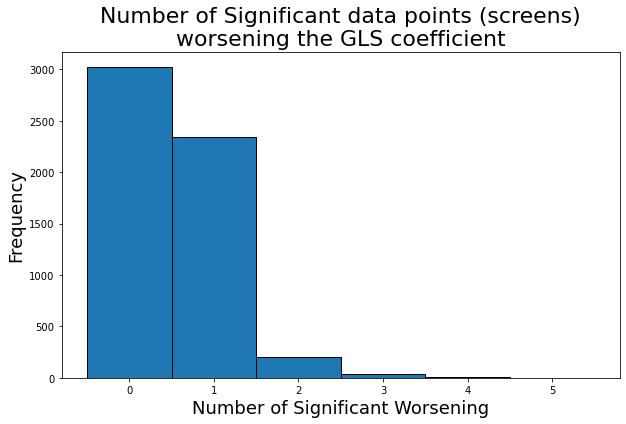

In [102]:
num_significant_worsening = results_df['num_significant_worsening']
# Determine the maximum number for setting bin edges
max_num = int(num_significant_worsening.max())
# Create bin edges aligned with integers
bins = [i - 0.5 for i in range(max_num + 2)]

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(num_significant_worsening, bins=bins, edgecolor='black')

# Setting the x-axis to show integer values
plt.xticks(range(max_num + 1))
plt.xlabel('Number of Significant Worsening', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
ttl = plt.title('Number of Significant data points (screens)\nworsening the GLS coefficient', fontsize = 22)

#### Next, we visually explore the gene pairs with a specific number of screens/datapoints that significantly influence the GLS regression coefficient. 

This gives a visual/qualitative sense of the nature of these gene pairs, particularly in terms of how outliers affect the GLS correlation.

,gene_pair,mean_coef,min_change,max_change,num_significant_worsening,gene_pair_str
2799,"(Rv1296, Rv2747)",1.156320,-0.076135,0.072327,0,Rv1296_Rv2747
3403,"(Rv1603, Rv2753c)",1.655388,-0.128831,0.120031,0,Rv1603_Rv2753c
3621,"(Rv1689, Rv3372)",0.949374,-0.083819,0.128051,0,Rv1689_Rv3372


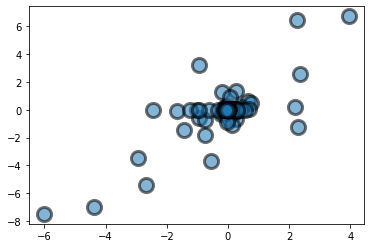

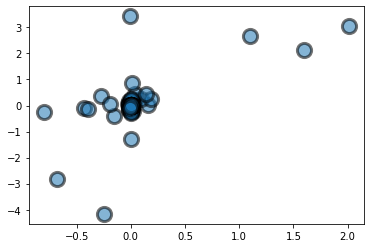

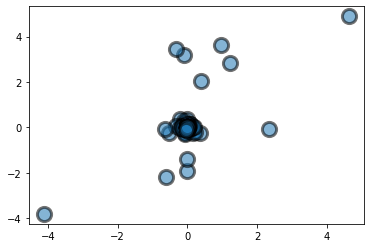

In [103]:
num_sig_wors = 0 # used to (randomly) select gene pairs with this number of screens/datapoints that significantly worsen the GLS regression coefficient 
sample_pairs = results_df[results_df.num_significant_worsening == num_sig_wors].gene_pair.sample(3).tolist()

for gp in sample_pairs:
    # GLS "warped" log2-fold changes
    warped_gene_x = get_warped_screen_for_gene(gp[0], df_lfc_gls, warped_screens)
    warped_gene_y = get_warped_screen_for_gene(gp[1], df_lfc_gls, warped_screens)
    plt.figure()
    plt.scatter(warped_gene_x, warped_gene_y, s = 200, alpha = 0.55, edgecolors='k', linewidths=3)
    
results_df[results_df.gene_pair.isin(sample_pairs)]

In [104]:
# Get a sense for the basic stats around the max/min effect on GLS coeff. from removing a single data point.  
min_change = results_df['min_change']
# Basic statistical summaries
print(min_change.describe())


count    5610.000000
mean       -0.257335
std         0.425605
min       -12.080858
25%        -0.303295
50%        -0.143621
75%        -0.055814
max        -0.000542
Name: min_change, dtype: float64


### Filtering Out Single-Outlier Driven Correlations
In this crucial step, we apply our defined criterion to isolate and remove gene pairs 
whose GLS correlation is significantly influenced by a single outlier. 

This is based on our threshold (~0.18), which we've established earlier.


In [108]:
# Exclude gene pairs with exactly one significant worsening instance.
results_df_filt = results_df[results_df.num_significant_worsening != 1]

# Apply this filtering to the original interaction DataFrame.
# We retain only those gene pairs whose interactions are robust against outliers.
df_interact_filt = df_interact[df_interact.sorted_gene_pair.isin(results_df_filt.gene_pair)].copy()
list_pairs = df_interact_filt.sorted_gene_pair.tolist()

# Compare the shape of the original and filtered DataFrames to understand the impact.
print("Original vs Filtered DataFrame shapes:", df_interact.shape, df_interact_filt.shape)

# The output shapes indicate how many gene pairs are excluded based on our robustness criterion.
# This step is key in ensuring the reliability of our subsequent analyses and interpretations.

Original vs Filtered DataFrame shapes: (5610, 4) (3268, 4)


# PART 2: Identifying Unique NN2 (nearest-neighbors of degree 2) Subgraphs

In this section, our goal is to identify distinct clusters or "modules" within the gene-gene co-essentiality network of Mycobacterium tuberculosis. 

We focus on constructing and analyzing second-nearest neighbor (NN2) subgraphs. 

An NN2 subgraph for a given gene comprises not only the genes directly correlated with it (first-nearest neighbors) but also those genes that are correlated with its first-nearest neighbors, thus extending the reach to second-nearest neighbors.

## What is an NN2 Subgraph?
### NN2 Subgraph: 
- It's a network cluster starting from a 'seed' gene and includes genes directly correlated with this seed (its nearest neighbors) and genes correlated with these neighbors.
- Purpose: By examining NN2 subgraphs, we aim to uncover more extensive and potentially meaningful gene interaction patterns that might not be evident from direct (nearest neighbor) interactions alone.

## Main Steps in the Analysis:
#### Subgraph Generation: 
For each gene in our dataset, we generate an NN2 subgraph using the correlations established from the GLS analysis.
#### Subgraph Normalization: 
To handle the asymmetry (where gene A's nearest neighbor might not consider A as its nearest neighbor), we standardize the representation of each subgraph.
#### Duplication Removal: 
We systematically identify and remove duplicate subgraphs. Duplication can occur due to the interconnected nature of gene relationships, where different seed genes might lead to similar or identical subgraphs.
#### Unique Subgraphs: 
Post-processing, we obtain a set of unique NN2 subgraphs. Each subgraph in this set represents a distinct cluster of gene interactions.


In [106]:
def get_NN12(rvid_query, df_interact):
    """
    Generate lists of first and second nearest neighbors (NN1 and NN2) for a given gene.

    Parameters:
    rvid_query (str): The RvID of the seed gene for which nearest neighbors are to be found.
    df_interact (DataFrame): A DataFrame containing gene interaction pairs (columns 'lead_gene' and 'partner_gene').

    Returns:
    tuple: A tuple containing two lists:
        - The first list contains the first nearest neighbors (NN1) of the query gene.
        - The second list contains the second nearest neighbors (NN2) of the query gene.

    The function works as follows:
    1. NN1 Identification:
       - Finds all genes that are directly correlated with the query gene (either as a lead_gene or partner_gene).
       - These genes are considered the first nearest neighbors (NN1).

    2. NN2 Identification:
       - Extends the search to genes that are correlated with the genes in the NN1 list.
       - These additional genes are considered the second nearest neighbors (NN2).

    Both lists are deduplicated and sorted to facilitate further analysis.
    """
    # first nearest neighbors: 
    df_NN1 = df_interact[(df_interact.lead_gene==rvid_query) | (df_interact.partner_gene==rvid_query)].copy()
    list_rvid_NN1 = list(set(df_NN1.lead_gene.tolist() + df_NN1.partner_gene.tolist()))
    list_rvid_NN1.sort()

    # second nearest neighbors: 
    df_NN2 = df_interact[ (df_interact.lead_gene.isin(list_rvid_NN1)) | (df_interact.partner_gene.isin(list_rvid_NN1))].copy()
    list_rvid_NN2 = list(set(df_NN2.lead_gene.tolist() + df_NN2.partner_gene.tolist()))
    list_rvid_NN2.sort()
    
    return list_rvid_NN1, list_rvid_NN2

## Identifying Unique NN2 Subgraphs for Each Gene

### Step 1: Extract Unique Genes from the Interaction Data

The interaction data contains pairs of genes. We first extract these genes
from each pair and create a list of unique genes to use as seeds for subgraph generation.


In [109]:
list_gene_1 = [gp[0] for gp in list_pairs]  # Extracting first genes from each pair
list_gene_2 = [gp[1] for gp in list_pairs]  # Extracting second genes from each pair
list_unique_genes = list(set(list_gene_1 + list_gene_2))  # Combining and deduplicating
# Display the count of unique genes
print(f"Number of unique genes in the interaction set: {len(list_unique_genes)}")

Number of unique genes in the interaction set: 1120


### Step 2: Generate NN2 Subgraphs for Each Unique Gene

We use each unique gene as a seed to generate its NN2 subgraph. 

This involves identifying not only the genes directly correlated with the seed (NN1) but also those correlated with its NN1 neighbors (NN2).


In [110]:
nn2_subgraphs = {}  # Dictionary to hold the NN2 subgraphs for each gene

for gene in tqdm(list_unique_genes):
    # Get the NN1 and NN2 lists for the current seed gene
    list_rvid_NN1, list_rvid_NN2 = get_NN12(gene, df_interact)
    
    # Create the subgraph set and include the seed gene itself
    subgraph = set(list_rvid_NN2)
    subgraph.add(gene)  # Adding the seed gene to its own subgraph

    # Store the subgraph in the dictionary
    nn2_subgraphs[gene] = subgraph

# At this point, nn2_subgraphs contains the NN2 subgraph for each unique gene in the dataset.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1120/1120 [00:02<00:00, 463.61it/s]


### Next, we implement a process to filter out similar subgraphs from our collection of NN2 subgraphs. 

Our aim is to ensure that each subgraph in our final analysis is distinct and unique, thereby enhancing the reliability and interpretability of our findings.



In [111]:
def jaccard_similarity(set1, set2):
    """
    Calculate the Jaccard similarity between two sets.

    The Jaccard similarity is a measure of how similar the two sets are, defined as
    the size of the intersection divided by the size of the union of the sets.

    Parameters:
    set1 (set): The first set for comparison.
    set2 (set): The second set for comparison.

    Returns:
    float: The Jaccard similarity coefficient between set1 and set2. This is a value
           between 0 and 1, where 0 means no similarity and 1 means the sets are identical.
    """
    intersection = len(set(set1).intersection(set2))
    union = len(set(set1).union(set2))
    return intersection / union

### Setting the Similarity Threshold: 
We define similarity_threshold as 0.25. This threshold determines how similar two subgraphs need to be to be considered duplicates. A higher threshold value would be more stringent.

#### Iterative Filtering Process:
We iterate through each subgraph in nn2_subgraphs. For each subgraph, we perform the following steps:

- #### Initial Assumption: 
    - We initially assume that each subgraph is unique.
- #### Comparison with Existing Subgraphs: 
    - We compare the current subgraph against those already identified as unique. We use the jaccard_similarity function for this comparison. If the similarity exceeds our predefined threshold, it indicates that the current subgraph is not distinct.
- #### Determining Uniqueness: 
    - If a subgraph is similar to any existing subgraph (based on our threshold), we mark it as non-unique and do not add it to our list of unique subgraphs.

#### Building the List of Unique Subgraphs: 
Only subgraphs that are determined to be unique are added to the filtered_subgraphs dictionary. This collection represents a set of distinct and non-redundant gene clusters.

By the end of this process, filtered_subgraphs contains a refined set of subgraphs, each representing a unique gene interaction pattern within the Mycobacterium tuberculosis genome.

In [118]:
# Threshold for filtering similar subgraphs
similarity_threshold = 0.25  # Adjust as needed

filtered_subgraphs = {}
for gene, subgraph in tqdm(nn2_subgraphs.items()):
    is_unique = True  # Assume the subgraph is unique initially
    
    # Compare with already filtered subgraphs
    for existing_subgraph in filtered_subgraphs.values():
        if jaccard_similarity(subgraph, existing_subgraph) >= similarity_threshold:
            is_unique = False
            break  # If similar to an existing subgraph, it's not unique

    # If the subgraph is unique, add it to the filtered subgraphs
    if is_unique:
        filtered_subgraphs[gene] = subgraph
        
print(f"Total NN2 Subgraphs: {len(nn2_subgraphs)}")
print(f"Unique NN2 Subgraphs after Filtering: {len(filtered_subgraphs)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1120/1120 [00:00<00:00, 6090.07it/s]

Total NN2 Subgraphs: 1120
Unique NN2 Subgraphs after Filtering: 236


#### We next visualize the distribution of sizes for the filtered NN2 subgraphs. 

This histogram will help us understand the range and commonality of subgraph sizes after the filtering process.



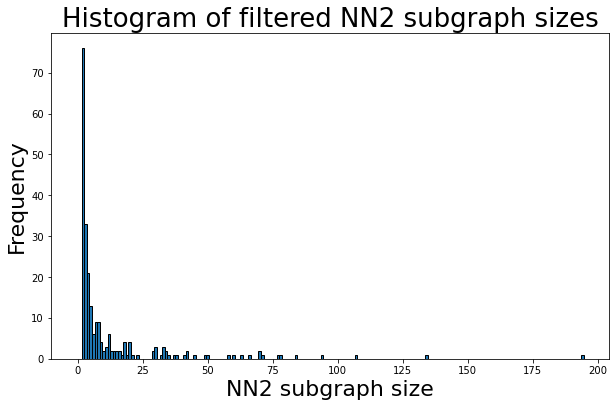

In [120]:
len_NN2 = np.array([len(val) for val in filtered_subgraphs.values()])
# Determine the range for your bins
max_size = len_NN2.max()
bins = np.arange(0, max_size + 2) - 0.5  # Bin edges aligned with integers

# Plotting the histogram
plt.figure(figsize=(10, 6))
hst = plt.hist(len_NN2, bins=bins, edgecolor='black')
plt.xlabel('NN2 subgraph size', fontsize = 22)
plt.ylabel('Frequency', fontsize = 22)
ttl = plt.title('Histogram of filtered NN2 subgraph sizes', fontsize = 26)

### Find all NN2 subgraphs that contain a specified gene of interest


In [124]:
def find_subgraphs_containing_gene(gene, filtered_subgraphs):
    """
    Find all NN2 subgraphs that contain the specified gene.

    Parameters:
    gene (str): The gene (RvID) to search for.
    nn2_subgraphs (dict): A dictionary of NN2 subgraphs.

    Returns:
    dict: A dictionary of subgraphs that contain the specified gene.
    """
    subgraphs_containing_gene = {}
    for key, subgraph in filtered_subgraphs.items():
        if gene in subgraph:
            subgraphs_containing_gene[key] = subgraph
    return subgraphs_containing_gene

In [126]:
# Example usage
gene_to_search = "Rv0101"  # Replace with the actual gene RvID

# Other seed genes to search for, which are relevant for different modules showcased in the manuscript: 
## MODULE #1a/b #### PDIM -- Rv2930
## MODULE #2 #### mycobactin -- Rv2378c
## MODULE #3 ##### Rv0096_Rv0101 -- Rv0101
## MODULE #4 ##### Biotin group -- Rv1569
## MODULE #5 #### Rv2691 group -- Rv2691
## MODULE #6 #### Cholesterol-related -- Rv3526
## MODULE #7 ##### Vitamin B12 (cobalamin) -- Rv0256c

subgraphs_with_gene = find_subgraphs_containing_gene(gene_to_search, filtered_subgraphs)

# Display the results
for key, subgraph in subgraphs_with_gene.items():
    print(f"The NN2 subgraph generated from using **{key}** as the seed gene contains **{gene_to_search}**.\nHere is the full subgraph: {sorted(subgraph)}")

The NN2 subgraph generated from using **Rv2069** as the seed gene contains **Rv0101**.
Here is the full subgraph: ['Rv0096', 'Rv0097', 'Rv0098', 'Rv0099', 'Rv0101', 'Rv0199', 'Rv2069']


In [129]:
# List of seed genes for different modules showcased in the manuscript
seed_genes = {
    "PDIM": "Rv2930",
    "Mycobactin": "Rv2378c",
    "Rv0096_Rv0101": "Rv0101",
    "Biotin Group": "Rv1569",
    "Rv2691 Group": "Rv2691",
    "Cholesterol-related": "Rv3526",
    "Vitamin B12 (Cobalamin)": "Rv0256c"
}

# Iterating through each module's seed gene
for module_name, seed_gene in seed_genes.items():
    subgraphs_with_gene = find_subgraphs_containing_gene(seed_gene, filtered_subgraphs)

    # Display the results for each module
    print(f"Module: {module_name} | Contains Gene: {seed_gene}")
    for key, subgraph in subgraphs_with_gene.items():
        subgraph_size = len(subgraph)
        print(f"  - Seed Gene for NN2 Subgraph (may be different from gene highlighted above): {key}")
        print(f"  - Contains Gene: {seed_gene}")
        print(f"  - NN2 Subgraph Size: {subgraph_size}")
        print(f"  - Full Subgraph: {sorted(subgraph)}\n")


Module: PDIM | Contains Gene: Rv2930
  - Seed Gene for NN2 Subgraph (may be different from gene highlighted above): Rv2941
  - Contains Gene: Rv2930
  - NN2 Subgraph Size: 11
  - Full Subgraph: ['Rv0554', 'Rv2928', 'Rv2930', 'Rv2931', 'Rv2932', 'Rv2933', 'Rv2934', 'Rv2935', 'Rv2939', 'Rv2940c', 'Rv2941']

Module: Mycobactin | Contains Gene: Rv2378c
  - Seed Gene for NN2 Subgraph (may be different from gene highlighted above): Rv2379c
  - Contains Gene: Rv2378c
  - NN2 Subgraph Size: 8
  - Full Subgraph: ['Rv2378c', 'Rv2379c', 'Rv2380c', 'Rv2381c', 'Rv2382c', 'Rv2383c', 'Rv2384', 'Rv2386c']

Module: Rv0096_Rv0101 | Contains Gene: Rv0101
  - Seed Gene for NN2 Subgraph (may be different from gene highlighted above): Rv2069
  - Contains Gene: Rv0101
  - NN2 Subgraph Size: 7
  - Full Subgraph: ['Rv0096', 'Rv0097', 'Rv0098', 'Rv0099', 'Rv0101', 'Rv0199', 'Rv2069']

Module: Biotin Group | Contains Gene: Rv1569
  - Seed Gene for NN2 Subgraph (may be different from gene highlighted above): Rv15

# EXTRA/PENDING
## Analyze what's up with the large subgraphs? 

In [121]:
# Define a size threshold for large subgraphs, this could be based on your histogram analysis
size_threshold = 20  # for example, subgraphs with size > 10

# Get a list of large subgraphs
large_subgraphs = {gene: subgraph for gene, subgraph in filtered_subgraphs.items() if len(subgraph) > size_threshold}

len(large_subgraphs)

36

In [122]:
# Function to compute pairwise Jaccard similarities between subgraphs
def pairwise_jaccard_similarities(subgraphs_dict):
    keys = list(subgraphs_dict.keys())
    similarities = {}
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            gene_i, gene_j = keys[i], keys[j]
            sim = jaccard_similarity(subgraphs_dict[gene_i], subgraphs_dict[gene_j])
            if sim > 0:  # Only consider non-zero similarities
                similarities[(gene_i, gene_j)] = sim
    return similarities

In [123]:
# Compute similarities between large subgraphs
large_subgraph_similarities = pairwise_jaccard_similarities(large_subgraphs)

# Sort by similarity score to see the most similar large subgraphs
sorted_similarities = sorted(large_subgraph_similarities.items(), key=lambda item: item[1], reverse=True)

# Print some of the most similar large subgraphs
for pair, sim in sorted_similarities[:10]:  # Top 10 most similar pairs
    print(f"Genes: {pair}, Jaccard Similarity: {sim}")


Genes: ('Rv2150c', 'Rv3320c'), Jaccard Similarity: 0.24489795918367346
Genes: ('Rv1611', 'Rv2611c'), Jaccard Similarity: 0.24444444444444444
Genes: ('Rv3320c', 'Rv2611c'), Jaccard Similarity: 0.24285714285714285
Genes: ('Rv3219', 'Rv0896'), Jaccard Similarity: 0.2422680412371134
Genes: ('Rv3219', 'Rv0291'), Jaccard Similarity: 0.2391304347826087
Genes: ('Rv3320c', 'Rv2050'), Jaccard Similarity: 0.23880597014925373
Genes: ('Rv3871', 'Rv3002c'), Jaccard Similarity: 0.23636363636363636
Genes: ('Rv1594', 'Rv0291'), Jaccard Similarity: 0.23605150214592274
Genes: ('Rv2764c', 'Rv2050'), Jaccard Similarity: 0.23333333333333334
Genes: ('Rv2393', 'Rv2235'), Jaccard Similarity: 0.22988505747126436


# How many are of size 2? 
# How many are manageable / intermediate size? 